<a href="https://colab.research.google.com/github/KeerthiVasan-ai/deep-learning-tools-lab/blob/main/1_Data_Augumentation_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.datasets import cifar10

In [ ]:
train_ds,test_ds = cifar10.load_data()
train_ds = tf.data.Dataset.from_tensor_slices(train_ds)

In [ ]:
def show_images(images):
  n = len(images)
  for index,image in enumerate(images):
    plt.subplot(1,n,index+1)
    plt.imshow(image)
    plt.axis("off")
  plt.show()

In [ ]:
IMG_SIZE = 32
augumentation_layer = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMG_SIZE,IMG_SIZE),
    tf.keras.layers.Rescaling(1/256),
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomRotation(factor=0.2),
    tf.keras.layers.RandomContrast(factor=(.2,.9))
])

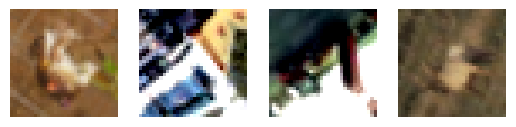

In [ ]:
augumented_images = train_ds.take(4).map(
    lambda x,y : augumentation_layer(x)
)
show_images(augumented_images)

In [ ]:
def prepare(images):
  images = images.map(
      lambda x,y : (augumentation_layer(x),y),num_parallel_calls=tf.data.AUTOTUNE
  )
  images = images.batch(64)
  return images.prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
processed_images = prepare(train_ds)
processed_images

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model = Sequential([
    layers.InputLayer(input_shape=(32, 32,3)),
    layers.Reshape((32,32,3)),
    # augumentation_layer,
    layers.Conv2D(16,4),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32,activation='relu'),
    layers.Dense(10,activation="softmax")
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 29, 29, 16)        784       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 32)                100384    
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                      

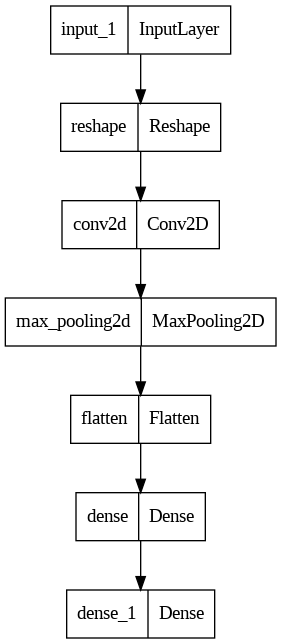

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = "adam",
    metrics=["accuracy"]
)

In [ ]:
model.fit(processed_images,epochs=2)

Epoch 1/2
782/782 [==============================] - 53s 65ms/step - loss: 1.9113 - accuracy: 0.3112
Epoch 2/2
782/782 [==============================] - 34s 44ms/step - loss: 1.7727 - accuracy: 0.3652


## Using tf.image

In [ ]:
image,label = next(iter(train_ds))

In [ ]:
def resize_and_rescale(img):
  img = tf.cast(img,tf.float32)
  img = tf.image.resize(img,(32,32))
  return img / 255
def augumented_layer(image,label):
  image = resize_and_rescale(image)
  image = tf.image.flip_left_right(image)
  image = tf.image.flip_up_down(image)
  image = tf.image.adjust_brightness(image,-.2)
  image = tf.image.adjust_contrast(image,2)
  image = tf.image.adjust_saturation(image,2)
  return image,label

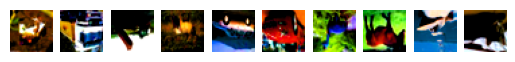

In [ ]:
augumented_image = train_ds.take(10).map(
    lambda x,y : augumented_layer(x,y)
)
show_images(
    augumented_image.map(
        lambda x,y:x
    )
)